# Param Init with setattr

In [2]:
import pandas as pd
import numpy as np

In [3]:
from brian2 import *
from brian2tools import *

prefs.codegen.target = 'cython'  # weave is not multiprocess-safe!

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


## Model Def

In [4]:
# Parameters
area = 20000*umetre**2
Cm = 1*ufarad*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
VT = -63*mV
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area),
                  'g_na': float(100*msiemens*cm**-2 * area),
                  'g_kd': float(30*msiemens*cm**-2 * area)}

dt = 0.01*ms

In [5]:
# Generate a step-current input and an "experimental" voltage trace
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt)), np.zeros(int(5*ms/dt))])*nA*10


In [6]:
defaultclock.dt = dt

In [7]:
# The model
eqsHH = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I(t))/Cm : volt
dm/dt = 0.32*(mV**-1)*(13.*mV-v+ VT)/
    (exp((13.*mV-v+VT)/(4.*mV))-1.)/ms*(1-m)-0.28*(mV**-1)*(v-VT-40.*mV)/
    (exp((v-VT-40.*mV)/(5.*mV))-1.)/ms*m : 1
dn/dt = 0.032*(mV**-1)*(15.*mV-v+VT)/
    (exp((15.*mV-v+VT)/(5.*mV))-1.)/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
g_na : siemens (constant)
g_kd : siemens (constant)
gl   : siemens (constant)
''')

In [10]:
start_scope()

In [8]:
I = TimedArray(input_current0, dt=dt)

G = NeuronGroup(1, eqsHH, method='exponential_euler')
G.v = El

In [11]:
params_correct

{'gl': 1e-08, 'g_na': 2e-05, 'g_kd': 6e-06}

In [20]:
params_correct = {'gl': float(5e-5*siemens*cm**-2 * area)*siemens,
                  'g_na': float(100*msiemens*cm**-2 * area)*siemens,
                  'g_kd': float(30*msiemens*cm**-2 * area)*siemens}

In [21]:
for k, v in params_correct.items():
    G.__setattr__(k, v)

In [22]:
G.__setattr__('gl', 'g_na')

In [8]:
G.set_states(params_correct, units=False)

In [8]:
mon = StateMonitor(G, 'v', record=0)
run(20*ms)

voltage = mon.v[0]/mV

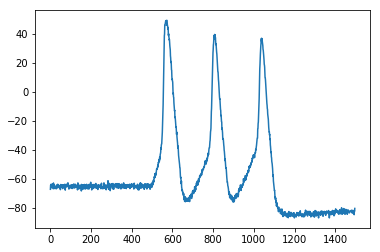

In [9]:
plot(voltage);